# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 29.9 MB/s eta 0:00:00


In [3]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed'
model_folder.mkdir(parents=True, exist_ok=True)
kaggle_api_folder = base_folder/'data/.kaggle'

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import torch
from torchvision import transforms
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.tuner import Tuner
from torch.optim.lr_scheduler import OneCycleLR

# from local pythion files
########## NEW ################### We changed the file
from multiclass_lightning_module_with_scheduler import MultiClassLightningModule
from data_module_dog_breed import DogBreedDataModule

from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

# <Font color = 'indianred'>**Setup Trainer**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            # Resize the shorter side of the image to (500, 375) pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            # Resize the shorter side of the image to 640 pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [6]:
# Define the model architecture and training parameters
num_features = 3 * 500 * 375
hidden_dim1 = 500
hidden_dim2 = 500
num_classes = 120
epochs = 10
learning_rate = 0.0001
max_learning_rate = 0.0005
batch_size = 1024
log_every_n_steps = 50
fraction_train = 0.8
seed = 42

optimizer_params = {'weight_decay': 10}

# Initialize the EarlyStopping callback
# early_stop_callback = EarlyStopping(
#     monitor='val_loss',  # metric to monitor
#     patience=5,  # number of epochs with no improvement
#     verbose=True,  # verbosity level
#     mode='min'  # 'min' will stop training when the quantity monitored has stopped decreasing
# )

model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/'two_layer/version_6',
                                            save_top_k=1, mode="max", monitor="val_metric", save_last=True)

# Set a random seed for reproducibility
torch.manual_seed(seed)

model = TwoLayerMLPBN(num_features, hidden_dim1, hidden_dim2, num_classes)

dm = DogBreedDataModule(data_dir=data_folder,
                        kaggle_api_folder=kaggle_api_folder,
                        train_transform=data_transforms["train"],
                        test_transform=data_transforms["test"],
                        batch_size=batch_size,
                        seed=seed,
                        fraction_train=fraction_train,
                        small_subset = False,
                        num_samples_small = 1024)

In [8]:
dm.prepare_data()
dm.setup(stage='fit')
len(dm.train_dataloader())

7

In [9]:
################ NEW ##################
scheduler_options = {'interval': 'step', 'frequency': 1}
scheduler_params = {'max_lr': max_learning_rate, 'total_steps':epochs * len(dm.train_dataloader())}
lr_monitor = LearningRateMonitor(logging_interval='step')
callbacks = [model_checkpoint_callback, lr_monitor ]
##############################################################

trainer = pl.Trainer(
        callbacks=callbacks,
        max_epochs=epochs,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices= 'auto',  # Uses all available GPUs if applicable
        deterministic=True,
        log_every_n_steps = log_every_n_steps,
        logger=CSVLogger(save_dir=model_folder/'logs', name="two_layer"),

    )



lightning_model = MultiClassLightningModule(model=model,
                                            optimizer_cls= torch.optim.AdamW,
                                            loss_fn=torch.nn.CrossEntropyLoss(),
                                            metric_cls=torchmetrics.Accuracy,
                                            num_classes=num_classes,
                                            learning_rate  = learning_rate,
                                            log_every_n_steps=log_every_n_steps,
                                            log_test_metrics=True,
                                            display_metrics=True,
                                            optimizer_params=optimizer_params,
                                            scheduler_cls=OneCycleLR, ##### NEW ############
                                            scheduler_params=scheduler_params, ##### NEW ############
                                            scheduler_options=scheduler_options,) ##### NEW ############


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# <Font color = 'indianred'>**Learning Rate Finder**

In [10]:
# Create a Tuner
# tuner = Tuner(trainer)

In [11]:
# tuner.lr_find??

In [12]:
# finds learning rate automatically
# lr_finder = tuner.lr_find(lightning_model, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')

In [13]:
# fig = lr_finder.plot(suggest=True)

In [14]:
# import pandas as pd
# pd.DataFrame(lr_finder.results)

In [15]:
# get suggestion
# new_lr = lr_finder.suggestion()
# print(new_lr)

In [16]:
# lightning_model.learning_rate = 0.001
# dm.batch_size = 256

In [17]:
trainer.fit(lightning_model, dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total pa

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.79, Val_Metric: 0.01 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.79, Val_Metric: 0.02 | Train_Loss: 4.77, Train_Metric: 0.02


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 4.64, Val_Metric: 0.03 | Train_Loss: 4.52, Train_Metric: 0.06


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 4.57, Val_Metric: 0.04 | Train_Loss: 4.34, Train_Metric: 0.10


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 4.53, Val_Metric: 0.04 | Train_Loss: 4.18, Train_Metric: 0.14


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 4.51, Val_Metric: 0.05 | Train_Loss: 4.04, Train_Metric: 0.19


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 4.50, Val_Metric: 0.06 | Train_Loss: 3.89, Train_Metric: 0.26


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 4.48, Val_Metric: 0.06 | Train_Loss: 3.76, Train_Metric: 0.33


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 4.47, Val_Metric: 0.06 | Train_Loss: 3.65, Train_Metric: 0.40


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 4.45, Val_Metric: 0.06 | Train_Loss: 3.57, Train_Metric: 0.45


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 4.44, Val_Metric: 0.06 | Train_Loss: 3.54, Train_Metric: 0.48


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# <Font color = 'indianred'>**Plot Losses**

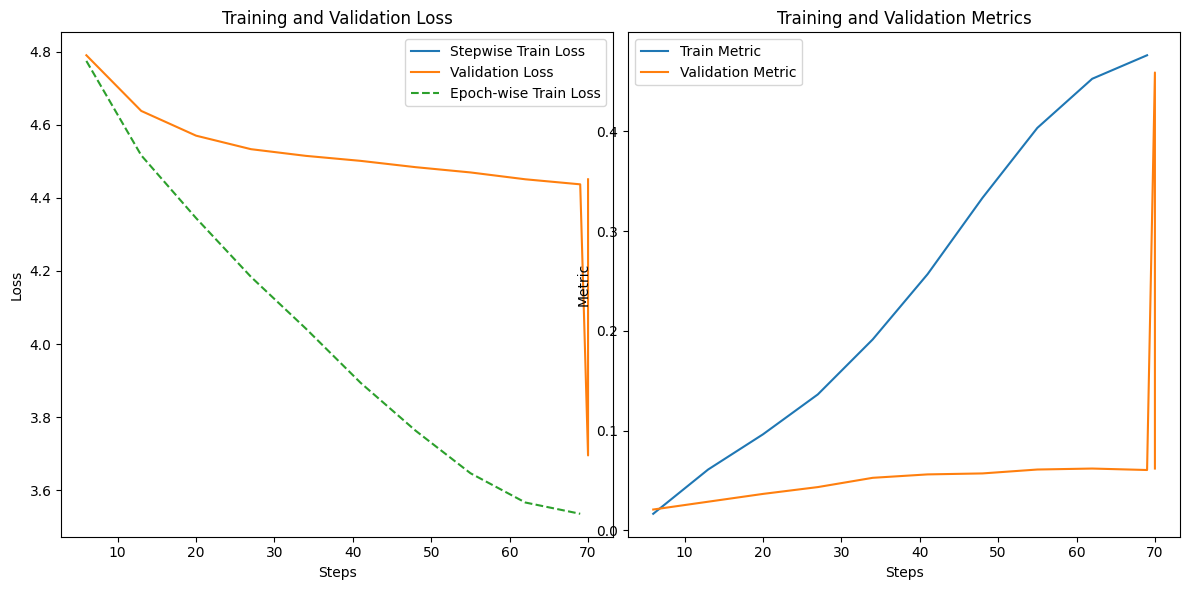

In [23]:
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)


# <Font color = 'indianred'>**Save Model**

In [19]:
# ckpt_path = trainer.logger.log_dir+ "/model.ckpt"
# print(ckpt_path)
# trainer.save_checkpoint(ckpt_path)

# <Font color = 'indianred'>**Evaluation**

In [24]:
ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt_path

'/content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_6/epoch=8-step=63.ckpt'

In [25]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
# test_acc = trainer.test(dataloaders=dm.test_dataloader(), ckpt_path=ckpt_path, verbose=False)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_6/epoch=8-step=63.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_6/epoch=8-step=63.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 3.69, Val_Metric: 0.46 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_6/epoch=8-step=63.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_6/epoch=8-step=63.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 4.45, Val_Metric: 0.06 | 

In [26]:
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
# print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Train Accuracy: 45.87
Validation Accuracy: 6.21
